<a href="https://colab.research.google.com/github/wkm200/seahorsecodex/blob/main/SeahorseNormalizationCellpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Automated Cell Counting and Seahorse Normalization**
This notebook was designed to count cells from the center of 96-well plates to normalize Seahorse data without an Incucyte. This setup assumes that images were taken as described below. After image processing, it uses Cellpose Prediction for 2D v0.3 (Carsen Stringer & Marius Pachitariu), as adapted from Pradeep Rajasekhar's notebook bringing Cellpose to Google Colab.

[Link to Google Colab Cellpose Notebook](https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/Cellpose_cell_segmentation_2D_prediction_only.ipynb#scrollTo=b8wPXz7PGNLt)

[Link to Cellpose Paper](https://www.nature.com/articles/s41592-020-01018-x)

Notebook created by Kyle Myers (myerswal@musc.edu).



---


# **Before Using This Notebook:**
##### This notebook was designed and tested following the protocol below.

### Staining and Imaging Protocol

####(a) `Staining`: Immediately after the Seahorse run, stain live cells with Hoechst 33342.


*   Constitute Hoechst 33342 stock per manufacturer instructions.
*   Dilute Hoechst 33342 to 400 uM in PBS (pH 7.4).
*   Create pre-mix final Hoechst solution at 40 uM in Beeson's buffer.
 *   `Volume Beeson's Buffer` = 135uL x (# Wells)
 *   `Volume 400 uM Hoechst` = 15uL x (# Wells)
*   Aspriate all media, then replace with 150 uL/well pre-mix final Hoechst solution.
*   Incubate 20-30 min at 37°C.
*   Wash with Beeson's buffer twice.

####(Optional) `Fixing Cells`:
*   Prepare fresh 4% PFA in PBS (pH 7.4).
*   Remove media.
*   Add 150 uL of 4% PFA to each well.
*   Incubate for 10 minutes at room temperature.
*   Wash with PBS three times, incubating for 5 minutes per each wash step.
*   *Cells can wrapped in foil and stored at 4°C for future imaging.*


####(b) `Imaging`: Using Andor BC43.  


*   Load 96-well Seahorse plate into microscope.
*   Swtich to 10X Objective.
*   Camera resolution should be set to 2040x1992 pixels.
*   Find "Seahorse" protocol, or make one as below:
 *   `Stitching` and `Deconvolution` turned on.
 *   `Montage` is set to 4x4.
 *   Ensure proper channel is selected.
*   **Navigate to wells**
  *   Under the protocol `Multi-position settings`, switch to `Well Navigation`, and double click the well to image. Adjust `z-position`, `laser-intensity` and `exposure`.
     *   **Recommended**: `z-position` ~ 11950 um `laser-intensity` ~ 1.8 and `exposure` ~ 500 ms.
*   Image each well and name as the position.



---


# **Using This Notebook:**

#### **Make sure you have GPU access enabled**:
Runtime > Change Runtime Type > Hardware accelerator > Select GPU

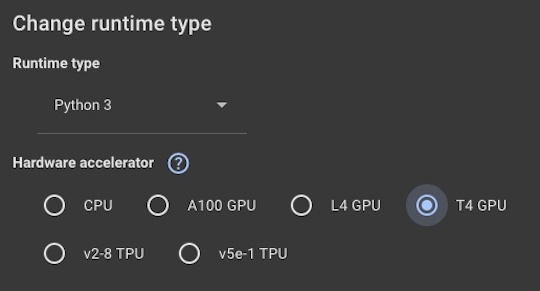

In [1]:
#@title ##**Step 1**: Install Dependencies
#@markdown Run this code block once per session, at the beginning of the session.
#@markdown
#@markdown When finished, the notebook will restart and might show an error message - *this can be ignored.*
!pip install imaris-ims-file-reader
!pip install cellpose==3.1.1
!pip install torch torchvision torchaudio
!pip install xlsxwriter

#Fix opencv error: ImportError: cannot import name '_registerMatType' from 'cv2.cv2'
#!pip install "opencv-python-headless<4.3"
#exit(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
%pip freeze > requirements.txt

In [2]:
#@title ##**Step 2**: Configure Cellpose, Download Models, and Check GPU Access
#@markdown Run this code block once per session.
#@markdown
#@markdown *Models (from Cellpose training data) will be downloaded when running for the first time. Re-run this code block if session crashes.*
#disabled installation and import of mxnet as pytorch is the default neural net
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from urllib.parse import urlparse
import shutil

#from tifffile import imread, imsave

print ("Downloading Models")
from cellpose import models,core
from cellpose import denoise, io

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  #Warnings from the ZeroCost StarDist notebook
  print(BOLD+UNDERLINE+'You do not have GPU access.'+END)
  print('Did you change your runtime ?')
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
  use_GPU=False
else:
  print(BOLD+UNDERLINE+"You have access to the GPU."+END+"\nDetails are:")
  print("*************************************************")
  !nvidia-smi
  use_GPU=True

print("*************************************************")
print("Libraries imported and configured")


You have access to the GPU.
Details are:
*************************************************
Thu Jun  5 15:22:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             25W /   70W |     104MiB /  15360MiB |      3%      Default |
|                                         |      

In [ ]:
#@title ## **Step 3**: Set Input Directory or Upload Zip Folder
#@markdown #### **i) Instructions**:
#@markdown Prepare a folder containing the image .ims files, and (optionally), the Excel .xlsx file from the Seahorse run.
#@markdown
#@markdown ##### **IMPORTANT**: .ims files should be named as the well to match Seahorse data (*eg*, D02.ims).
#@markdown
#@markdown If you would like to automatically normalize your Seahorse data using the output of this code, please include the unmodified Excel file from Wave, and check the box below:
Normalize_Seahorse_Data = True #@param {type:"boolean"}

#@markdown #### **ii) Choose your input method**:
#@markdown **Option 1: Upload a Zip Folder**
#@markdown 1. Select Upload a Zip Folder below.
#@markdown 2. Click the folder icon in the left-hand menu in Colab, then drag the .zip folder into the File menu.
#@markdown 3. Right-click the zip folder > Copy path. Paste this path into the Folder_Path field below.
#@markdown 4. The script will extract the contents automatically.
Upload_Zip = False #@param {type:"boolean"}


#@markdown **Option 2 (*Recommended*): Use a folder in Google Drive or Colab**
#@markdown 1. Click the folder icon in the left-hand menu in Colab.  *To link Google Drive, click on the Mount Drive icon.*
#@markdown 2. Find your folder and upload files there, if needed.
#@markdown 3. Right-click > Copy path. Paste the full path to the folder in the Folder_Path field above.
#@markdown
#@markdown
Folder_Path = "" #@param {type:"string"}
#@markdown ####**iii)** [Optional] **For multi-channel images, specify the nuclear channel**:
#@markdown For single, nuclear channel images, keep value at 1.
Use_nuclear_channel= True
Nuclear_channel="1" #@param[1,2,3]
nuclear_channel=int(Nuclear_channel)

#@markdown ####**iv) Choose whether to crop to the center of the well**
#@markdown If you would like to crop to the center of the well (recommended if cells are even), check the box below. Otherwise, the code will account for the full well.
Crop_to_Center = True  #@param {type:"boolean"}

import os

if Upload_Zip:
    # Handle zip file extraction
    if not Folder_Path.endswith(".zip"):
        raise ValueError("The specified path is not a zip file. Please provide a valid zip file path.")

    extracted_folder = os.path.join(Folder_Path.rsplit("/", 1)[0], "Extracted_Files")
    os.makedirs(extracted_folder, exist_ok=True)

    print(f"Extracting contents of the zip file: {Folder_Path}")
    with zipfile.ZipFile(Folder_Path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

    print(f"Contents of the zip folder have been extracted to: {extracted_folder}")
    input_dir = extracted_folder  # Update input directory to the extracted folder
else:
    # Use specified folder path directly
    input_dir = Folder_Path

# Define directories for processing
# Place output directories within the input directory
tiff_dir = os.path.join(input_dir, "tiff_conversion")  # Temporary directory to store converted TIFF files
output_dir = os.path.join(input_dir, "output")  # Directory to save processed files
cropped_dir = os.path.join(output_dir, "Cropped")  # Subdirectory for cropped images

# Check input directory for necessary files
ims_files = [f for f in os.listdir(input_dir) if f.endswith(".ims")]
if len(ims_files) == 0:
    raise FileNotFoundError("No .ims files found in the input directory. Please check your input path or ensure the folder contains valid .ims files.")

if Normalize_Seahorse_Data:
    excel_files = [f for f in os.listdir(input_dir) if f.endswith((".xlsx", ".xls"))]
    if len(excel_files) == 0:
        raise FileNotFoundError("No Excel file found in the input directory for normalization. Please add your Seahorse Excel file.")

# Ensure the directories for output exist
os.makedirs(tiff_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(cropped_dir, exist_ok=True)

# Log directory setup
print("Input directory is set to:", input_dir)
print("TIFF conversion directory is set to:", tiff_dir)
print("Output directory is set to:", output_dir)
print("Cropped images directory is set to:", cropped_dir)

In [ ]:
# There needs to be something here so that the input files and parameters have a sanity check.
# To include checks for format of excel sheet (if not in expected format, user is given template to download)
#, pixel size (if they say they want to detect pixel size we should verify we detected the correct pixel size), etc

In [ ]:
#@title ##**Step 4**: Process imaging files
#@markdown This code block accomplishes several tasks:
#@markdown - Convert .ims files to .tiff
#@markdown - Determine and apply optimal histogram to images
#@markdown - Align all images, then crop to fit specifications (*ie*, whole well, or area between posts)
#@markdown
#@markdown The code will automatically save the processed images (cropped and uncropped).
#@markdown
# save_uncropped = True #@param {type:"boolean"}
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.exposure import rescale_intensity
import cv2
from imaris_ims_file_reader import ims
import shutil
import contextlib
import sys

# Ensure the directories exist
os.makedirs(tiff_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(cropped_dir, exist_ok=True)

terminalwidth = 80

# Suppress output context manager during .ims file conversion
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Function to convert .ims files to .tiff
def convert_ims_to_tiff(ims_dir, tiff_output_dir):
    print('─' * 80)
    print("####### STEP 1: CONVERT IMS FILES TO TIFF #######".center(terminalwidth))
    print('─' * 80)
    created_directories = []  # List to track unintentionally created directories
    ims_files = [f for f in os.listdir(ims_dir) if f.endswith(".ims")]
    for ims_file in ims_files:
        ims_path = os.path.join(ims_dir, ims_file)
        tiff_path = os.path.join(tiff_output_dir, f"{os.path.splitext(ims_file)[0]}.tiff")
        print(f"Converting {ims_file} to {os.path.basename(tiff_path)}...")
        try:
            with suppress_output():  # Suppress output from ims reader
                reader = ims(ims_path)
                reader.save_multilayer_tiff_stack(
                    location=tiff_path,
                    time_point=0,
                    channel=(nuclear_channel - 1),
                    resolution_level=0
                )
                reader.close()

            unintended_dir = os.path.join("/content", f"{os.path.splitext(ims_file)[0]}.tiff")
            if os.path.isdir(unintended_dir):
                created_directories.append(unintended_dir)
        except Exception as e:
            print(f"Error converting {ims_file}: {e}")

    print("\nCleaning up unintended directories...")
    for dir_path in created_directories:
        try:
            print(f"Removing created directory: {dir_path}")
            shutil.rmtree(dir_path)
        except Exception as e:
            print(f"Failed to remove directory {dir_path}: {e}")

    print(f"All IMS files converted to TIFF in {tiff_output_dir}\n")

# Convert .ims files to .tiff
convert_ims_to_tiff(input_dir, tiff_dir)
input_dir = tiff_dir  # Update input directory

# Step 2: Determine and apply optimal histogram settings
print('─' * 80)
print("####### STEP 2: DETERMINE AND APPLY OPTIMAL HISTOGRAM SETTINGS #######".center(terminalwidth))
print('─' * 80)

image_files = [f for f in os.listdir(input_dir) if f.endswith((".tif", ".tiff"))]
all_histograms = []

for file in image_files:
    image_path = os.path.join(input_dir, file)
    image = imread(image_path)
    if image.dtype != np.uint16:
        print(f"Skipping {file}: Not a 16-bit image.")
        continue
    hist, _ = np.histogram(image, bins=65536, range=(0, 65535))
    all_histograms.append(hist)

average_histogram = np.mean(all_histograms, axis=0)
max_count = np.max(average_histogram)
threshold_30 = max_count * 0.30
threshold_5 = max_count * 0.05
bin_25 = np.argmax(average_histogram >= threshold_30)
min_bin = bin_25 + (bin_25 * 0.05)
min_bin = round(min_bin)
max_bin = len(average_histogram) - 1 - np.argmax(average_histogram[::-1] >= threshold_5)
adjusted_max_bin = round(max_bin + (max_bin * 0.3))
adjusted_max_bin = min(adjusted_max_bin, 65535)

print(f"Brightness/Contrast settings: Min = {min_bin}, Max = {adjusted_max_bin}\n")

# Step 3: Apply brightness/contrast and crop images
print('─' * 80)
print("####### STEP 3: ALIGN IMAGES THEN CROP #######".center(terminalwidth))
print('─' * 80)

for file in image_files:
    image_path = os.path.join(input_dir, file)
    image = imread(image_path)
    if image.dtype != np.uint16:
        print(f"Skipping {file}: Not a 16-bit image.")
        continue

    adjusted_image = rescale_intensity(image, in_range=(min_bin, adjusted_max_bin), out_range=(0, 65535)).astype(np.uint16)

for file in image_files:
    image_path = os.path.join(input_dir, file)
    image = imread(image_path)
    if image.dtype != np.uint16:
        print(f"Skipping {file}: Not a 16-bit image.")
        continue

    adjusted_image = rescale_intensity(image, in_range=(min_bin, adjusted_max_bin), out_range=(0, 65535)).astype(np.uint16)
    cropped_working_image = adjusted_image.copy()
    cropped_working_image_8bit = (cropped_working_image / 256).astype(np.uint8)

    # Thresholding and detecting the largest particle
    _, binary_image = cv2.threshold(cropped_working_image_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred_image = cv2.GaussianBlur(binary_image, (0, 0), 4)
    _, binary_blurred = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dilated_image = cv2.dilate(binary_blurred, np.ones((3, 3), np.uint8), iterations=200)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated_image, connectivity=8)

    min_area = 10_000_000
    particle_stats = [stats[i] for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > min_area]

    if particle_stats:
        largest_particle = particle_stats[0]
        x, y, w, h = largest_particle[cv2.CC_STAT_LEFT], largest_particle[cv2.CC_STAT_TOP], \
                     largest_particle[cv2.CC_STAT_WIDTH], largest_particle[cv2.CC_STAT_HEIGHT]

        if Crop_to_Center:
            cropped_image = cropped_working_image[y:y+h, x:x+w]
            center_y, center_x = cropped_image.shape[0] // 2, cropped_image.shape[1] // 2
            radius = 1500
            circular_mask = np.zeros_like(cropped_image, dtype=np.uint8)
            cv2.circle(circular_mask, (center_x, center_y), radius, 255, -1)
            circular_roi = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

            nonzero_y, nonzero_x = np.where(circular_mask > 0)
            y_min, y_max = nonzero_y.min(), nonzero_y.max()
            x_min, x_max = nonzero_x.min(), nonzero_x.max()
            circular_roi_cropped = circular_roi[y_min:y_max, x_min:x_max]

            cropped_output_path = os.path.join(cropped_dir, f"cropped_{file}")
            imsave(cropped_output_path, circular_roi_cropped)
            print(f"Processed and cropped image: {file}")
        else:
            # Crop as usual, then trim 200px from all sides
            cropped_image = cropped_working_image[y:y+h, x:x+w]
            new_x, new_y = x + 100, y + 100  # Shift start
            new_w, new_h = w - 200, h - 200  # Reduce width/height
            cropped_image = cropped_working_image[new_y:new_y+new_h, new_x:new_x+new_w]

            # Save modified cropped image
            cropped_output_path = os.path.join(cropped_dir, f"cropped_{file}")
            imsave(cropped_output_path, cropped_image)
            print(f"Processed and cropped image: {file}")

print('─' * 80)
print("####### PROCESSING COMPLETE #######".center(terminalwidth))
print('─' * 80)
print(f"Uncropped images saved to {output_dir}.")
print(f"Processed cropped images saved to {cropped_dir}.")


In [ ]:
#@title ## **Step 5**: Load Images and Set Up Cellpose Parameters
#@markdown #### **Required: Load Images and Define Thresholds**
#@markdown This step prepares your images for segmentation using Cellpose. It automatically:
#@markdown - Loads processed `.tif` files from the cropped output directory.
#@markdown - Sets the Cellpose nuclear model for segmentation.
#@markdown - Defines default threshold parameters for the segmentation process.
#@markdown
#@markdown This code block needs to be run once per session, and anytime parameters are changed.
#@markdown

from cellpose import denoise, models, io, plot, utils
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_ubyte
import os

import warnings
warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`",
    category=FutureWarning
)

# Directory containing cropped processed images
input_dir = cropped_dir  # Use cropped_dir from the previous processing step
save_dir = os.path.join(input_dir, "Masks")  # Directory to save segmentation masks
os.makedirs(save_dir, exist_ok=True)

# Load all `.tif` images
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".tiff")]
if len(files) == 0:
    raise FileNotFoundError("No .tiff files found in the cropped output directory. Ensure Step 4 completed successfully.")

# Load images into memory
imgs = []
for f in files:
    img = io.imread(f)
    if len(img.shape) == 3 and img.shape[0] == min(img.shape):  # Ensure correct channel order
        img = img.transpose(1, 2, 0)
    imgs.append(img)

print(f"Loaded {len(imgs)} images for segmentation.")



# Define segmentation thresholds
#@markdown ---
#@markdown #### **Cellpose Parameters**
#@markdown
# Set up Cellpose model
#@markdown ##### **`model_type` Parameter**:
#@markdown - `nuclei` was trained on nuclei using diameter of 17 px.
#@markdown - `cyto3` is a super-generalist model; trained on cell diameter of 30 px.

model_type = "cyto3" #@param ["nuclei", "cyto3"] {allow-input: true}
channels = [(int(Nuclear_channel)-1), 0]  # [int(Nuclear_channel), 0] # Use nuclear channel set earlier
#@markdown ##### **`restore` Parameter**: Default = `oneclick`
#@markdown - `denoise`: Specialist model. Use if raw images are grainy.
#@markdown - `deblur`: Specialist model.Use if raw images are blurry, soft, or have out-of-focus haze.
#@markdown - `upsample`: Specialist model. Use if raw images are low-resolution with large pixels
#@markdown - `oneclick`: Generalist model. Use if you are not sure which artifact dominates.
#@markdown
#@markdown *Use specialist model if you know dominant artifact, otherwise use oneclick.*
restore = "oneclick" #@param ["denoise", "deblur", "upsample", "oneclick"]
model = denoise.CellposeDenoiseModel(gpu=True, model_type=model_type,
                                     restore_type=f"{restore}_{model_type}")

#@markdown ##### **`Flow_Threshold` Parameter**:
#@markdown - **Increase** this threshold if Cellpose is not returning as many masks as you’d expect.
#@markdown - **Decrease** this threshold if Cellpose is returning too many ill-shaped masks.
#@markdown
#@markdown ##### **`Cell_Probability_Threshold` Parameter**:
#@markdown - **Decrease** this threshold if Cellpose is not returning as many masks as you’d expect or if masks are too small.
#@markdown - **Increase** this threshold if Cellpose is returning too many masks, especially from dim areas.
#@markdown
#@markdown It is *recommended* to start with:
#@markdown - ###### `Flow_Threshold` = 0.4
#@markdown - ###### `Cell_Probability_Threshold` = 0
#@markdown
#@markdown **IMPORTANT NOTE!** - Do not worry if Cellpose is returning masks in the empty region outside of the well border - these will be automatically excluded when counting cells.
#@markdown
#@markdown For more detailed information on these parameters, visit: https://cellpose.readthedocs.io/_/downloads/en/latest/pdf/
Flow_Threshold = 0.4  #@param {type:"slider", min:0.1, max:1.1, step:0.1}
Cell_Probability_Threshold = 0  #@param {type:"slider", min:-6, max:6, step:1}
flow_threshold = Flow_Threshold
cellprob_threshold = Cell_Probability_Threshold

# Optional: Test segmentation on one example image
# if Test_on_Example_Image:
#     print("Testing segmentation on an example image...")
#     example_image_idx = 0  # Always use the first image for testing
#     img1 = imgs[example_image_idx]
#@markdown ---
#@markdown #### **Optional: Test on an Example Image**
#@markdown It is **recommended** to test on a single image during the first run with a new dataset. This ensures your segmentation thresholds are set correctly.
#@markdown - If enabled, the code will display segmentation results for one image.
#@markdown - If disabled, it will only define the thresholds for subsequent runs.
Test_on_Example_Image = True #@param {type:"boolean"}
#@markdown Provide the name of your test file, or keep blank if not using example image.
if Test_on_Example_Image:

    well = "" #@param {type:"string", placeholder:"Type name of well (eg, D5)"}

    if Crop_to_Center:
        example_image_name = f"cropped_{well}"
    else:
        example_image_name = well

    example_image_name = example_image_name.lower()  # Case-insensitive comparison

    # Find matching files
    matches = [f for f in files if example_image_name in f.lower()]

    if len(matches) == 0:
        raise ValueError(f"No files found containing '{example_image_name}'. Check your input.")
    elif len(matches) > 1:
        raise ValueError(f"Multiple files match '{example_image_name}': {matches}. Please be more specific (e.g., '{matches[0]}').")

    selected_file = matches[0]
    selected_idx = files.index(selected_file)  # Get index of selected image

    print(f"Testing segmentation on example image: {selected_file}")
    img1 = imgs[selected_idx]

    masks, flows, styles, imgs_dn = model.eval(
        img1,
        diameter=None,
        flow_threshold=flow_threshold,
        cellprob_threshold=cellprob_threshold,
        channels=channels
    )

    # Convert to 8-bit for display
    if img1.dtype != 'uint8':
        img1 = img_as_ubyte(img1)

    # Display the segmentation result
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # 0 ▸ original image
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title("Original"); axes[0].axis("off")

    # 1 ▸ denoised image
    axes[1].imshow(imgs_dn, cmap='gray')
    axes[1].set_title("Denoised"); axes[1].axis("off")

    # 2 ▸ outlines over denoised
    axes[2].imshow(imgs_dn, cmap='gray')
    for o in utils.outlines_list(masks):
        axes[2].plot(o[:, 0], o[:, 1], color='lime', linewidth=0.41, alpha=0.6)
    axes[2].set_title("Outlines"); axes[2].axis("off")



else:
    print("Skipping example image testing. Thresholds are set for segmentation.")

print(f"Segmentation parameters:\n- Flow Threshold: {flow_threshold}\n- Cell Probability Threshold: {cellprob_threshold}")
#@markdown **Note**: To enlarge the test image, click on it once in the output.

#@markdown ---
#@markdown The Colab session is likely to restart after long runs of this code block, but this should not affect your data. Allow the notebook to reconnect, and the test image will later appear.

In [ ]:
#@title ## **Step 6**: Segment, Filter, and Normalize Data
#@markdown #### **This step will**:
#@markdown 1. **Segment cells** in the cropped images using Cellpose.
#@markdown 2. **Filter Cellpose masks** to include only cells within the well area.
#@markdown 3. **Count cells** in each well and map the counts to the correct well name.
#@markdown 4. **Normalize the Seahorse Excel file** based on the cell counts:
#@markdown    - Normalized values are expressed as Measurement/10³ Cells.
#@markdown    - Percent values are based on the 3rd basal measurement for each well.
#@markdown
#@markdown #### **Outputs include**:
#@markdown - Segmentation masks and optional flow images.
#@markdown - `CellCounts.csv` with well-wise cell counts.
#@markdown - A processed Excel file with the following sheets:
#@markdown     - `Absolute_RawData`
#@markdown     - `Absolute_Normalized`
#@markdown     - `Percent`
#@markdown     - `Percent_Normalized`
#@markdown ---
#@markdown #### **Parameters**:
#@markdown `Save_Preview` is useful for checking segmentation quality. When enabled, the pipeline will create a PNG that contains
#@markdown the original field, Cellpose outlines, mask, and flow overlay,
#@markdown similar to the test image you saw in Step 5. **Note**: *Preview images are created before filtering masks.*
Save_Preview = True  #@param {type:"boolean"}

import os
import numpy as np
import pandas as pd
import cellpose
from cellpose import models
from skimage.io import imread, imsave
from skimage.measure import label
from skimage.draw import disk
import tifffile as tiff
import zipfile
import csv
import warnings
from datetime import datetime
import platform
from importlib import metadata as importlib_metadata
from concurrent.futures import ThreadPoolExecutor

# Suppress specific FutureWarning from torch
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

# Directories
original_input_dir = Folder_Path  # Original directory for Excel file
masks_dir = os.path.join(cropped_dir, "Masks")
processed_maps_dir = os.path.join(masks_dir, "ProcessedMaps")
os.makedirs(masks_dir, exist_ok=True)
os.makedirs(processed_maps_dir, exist_ok=True)
if Save_Preview:
    previews_dir = os.path.join(masks_dir, "Segmentation_Previews")
    os.makedirs(previews_dir, exist_ok=True)

# ─── Write run parameters ──────────────────────────────────────────
params_path = os.path.join(masks_dir, "parameters.txt")
try:
    cp_version = cellpose.__version__
except AttributeError:
    cp_version = importlib_metadata.version("cellpose")
with open(params_path, "w") as f:
    f.write(f"Analysis date/time : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Python version     : {platform.python_version()}\n")
    f.write(f"cellpose version   : {cp_version}\n")
    f.write("Cellpose parameters:\n")
    f.write(f"  model_type        = {model_type}\n")
    f.write(f"  restore_type      = {restore}_{model_type}\n")
    f.write(f"  flow_threshold    = {flow_threshold}\n")
    f.write(f"  cellprob_threshold= {cellprob_threshold}\n")
print(f'Parameter log written to {params_path}')
# ──────────────────────────────────────────────────────────────────

# Step 1: Run Cellpose segmentation
print('─' * 80)
step1 = "####### STEP 1: RUN CELLPOSE SEGMENTATION #######"
print(step1.center(80))
print('─' * 80)

# Initialize ThreadPool for more rapid image saving
io_pool = ThreadPoolExecutor(max_workers=4)

# Helper
def _save_fig(fig_obj, out_path):
    fig_obj.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig_obj)

# Initialize the Cellpose model
model_type = model_type
channels = [(int(Nuclear_channel) - 1), 0]
model = denoise.CellposeDenoiseModel(gpu=True, model_type=model_type,
                                     restore_type=f"{restore}_{model_type}")

total_files = len(files)  # Get the total number of files to process

for img_idx, img_path in enumerate(files, start=1):  # Start counting from 1
    img = imread(img_path)
    file_name = os.path.basename(img_path).replace("cropped_", "").replace(".tiff", "")
    print(f"Segmenting: {file_name} ({img_idx}/{total_files})...")

    masks, flows, styles, imgs_dn = model.eval(
            img,
            diameter=None,
            flow_threshold=flow_threshold,
            cellprob_threshold=cellprob_threshold,
            channels=channels
    )

    # Save the mask
    mask_output_path = os.path.join(masks_dir, f"MASK_{file_name}.tiff")
    io_pool.submit(imsave, mask_output_path, masks.astype(np.uint16), check_contrast=False)


    if Save_Preview:
        # Display the segmentation result
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        # 0 ▸ original image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Original"); axes[0].axis("off")

        # 1 ▸ denoised image
        axes[1].imshow(imgs_dn, cmap='gray')
        axes[1].set_title("Denoised"); axes[1].axis("off")

        # 2 ▸ outlines over denoised
        axes[2].imshow(imgs_dn, cmap='gray')
        for o in utils.outlines_list(masks):
            axes[2].plot(o[:, 0], o[:, 1], color='lime', linewidth=0.41, alpha = 0.5)
        axes[2].set_title("Outlines"); axes[2].axis("off")

        preview_path = os.path.join(previews_dir, f"PREVIEW_{file_name}.png")
        io_pool.submit(_save_fig, fig, preview_path)

io_pool.shutdown(wait=True)                 # flush outstanding writes
print(f"Segmentation complete. Masks saved to {masks_dir}.")

if Save_Preview:
    print(f"Preview evaluation images saved to {previews_dir}.")

# Step 2: Filter Cellpose masks
print('─' * 80)
step2 = "####### STEP 2: FILTER MASKS AND COUNT CELLS #######"
print(step2.center(80))
print('─' * 80)

csv_path = os.path.join(processed_maps_dir, "CellCounts.csv")
with open(csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Well", "CellCount"])

    for mask_file in os.listdir(masks_dir):
        if not mask_file.endswith(".tiff") or not mask_file.startswith("MASK_"):
            continue

        mask_path = os.path.join(masks_dir, mask_file)
        mask = tiff.imread(mask_path)
        file_name = mask_file.replace("MASK_", "").replace(".tiff", "")

        # Create circular ROI
        height, width = mask.shape
        center_y, center_x = height // 2, width // 2
        radius = int(0.98 * min(height, width) / 2)
        roi_mask = np.zeros_like(mask, dtype=bool)
        rr, cc = disk((center_y, center_x), radius, shape=mask.shape)
        roi_mask[rr, cc] = True

        # Define exclusion zones if not cropping to center
        if not Crop_to_Center:
            exclusion_mask = np.zeros_like(mask, dtype=bool)
            exclusion_zones = [(4196, 1458, 512), (4196, 4980, 512), (1146, 3216, 512)]
            for ex_x, ex_y, ex_radius in exclusion_zones:
                rr, cc = disk((ex_y, ex_x), ex_radius, shape=mask.shape)
                exclusion_mask[rr, cc] = True

            # Directly remove labels that appear in exclusion zones
            mask[np.isin(mask, np.unique(mask[exclusion_mask]))] = 0

        # Apply circular ROI filtering
        mask[~roi_mask] = 0

        # Count remaining unique labels
        unique_labels = np.unique(mask)
        unique_labels = unique_labels[unique_labels != 0]  # Exclude background

        # Save filtered mask
        filtered_output_path = os.path.join(processed_maps_dir, f"{file_name}_label.tiff")
        tiff.imwrite(filtered_output_path, mask)

        # Write cell count to CSV
        csv_writer.writerow([file_name, len(unique_labels)])
        print(f"Processed: {file_name} - Cell count: {len(unique_labels)}")


print(f"Cell counts saved to {csv_path}. Filtered masks saved to {processed_maps_dir}.")

# Step 3: Normalize Seahorse data
print('─' * 80)
step3 = "####### STEP 3: NORMALIZE SEAHORSE DATA #######"
print(step3.center(80))
print('─' * 80)

# Locate Seahorse Excel file
excel_files = [f for f in os.listdir(original_input_dir) if f.endswith((".xlsx", ".xls"))]
if len(excel_files) == 0:
    raise FileNotFoundError("No Seahorse Excel file found in the input directory.")
excel_file_path = os.path.join(original_input_dir, excel_files[0])

# Read Seahorse data
rate_sheet = pd.read_excel(excel_file_path, sheet_name="Rate")
filtered_rate = rate_sheet[~rate_sheet["Group"].isin(["Blank", "Background"])]

# Load cell counts
cell_counts = pd.read_csv(csv_path)
cell_counts.set_index("Well", inplace=True)

# Normalize data
#@markdown **Select which type of data to normalize:**
selected_columns = "OCR" #@param ["OCR", "ECAR", "PER"]
filtered_rate = filtered_rate[["Time", "Measurement", "Well", selected_columns]].copy()

# Normalize absolute data
def normalize(row):
    well = row["Well"]
    if well in cell_counts.index:
        row[selected_columns] = row[selected_columns] / (cell_counts.loc[well, "CellCount"] / 1000)  # Normalize to 10^3 cells
    return row
normalized_rate = filtered_rate.apply(normalize, axis=1)

# Calculate Percent (raw data divided by raw 3rd basal)
basal_values_raw = filtered_rate[filtered_rate["Measurement"] == 3]
basal_factors_raw = basal_values_raw.set_index("Well")[[selected_columns]]

def percent_raw_basal(row):
    well = row["Well"]
    if well in basal_factors_raw.index:
        row[selected_columns] = row[selected_columns] / basal_factors_raw.loc[well, selected_columns]
    return row
percent_raw_rate = filtered_rate.apply(percent_raw_basal, axis=1)
percent_raw_rate[selected_columns] *= 100  # Convert to percentage

# Save to Excel
output_file = os.path.join(processed_maps_dir, "Processed_Seahorse_Data.xlsx")
with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    # Sheet 1: Absolute Raw Data
    filtered_rate.pivot(index="Time", columns="Well", values=selected_columns).to_excel(writer, sheet_name="Absolute_RawData")

    # Sheet 2: Absolute Normalized Data
    normalized_rate.pivot(index="Time", columns="Well", values=selected_columns).to_excel(writer, sheet_name="Absolute_Normalized")

    # Sheet 3: Percent (raw data divided by raw 3rd basal, converted to percentage)
    percent_raw_rate.pivot(index="Time", columns="Well", values=selected_columns).to_excel(writer, sheet_name="Percent")

    # Sheet 4: Cell Counts (contents of the CSV file)
    cell_counts.reset_index().to_excel(writer, sheet_name="CellCounts", index=False)

print(f"Normalization complete. Processed data saved to {output_file}.")
